# Testing FFNN on classification problems

In [1]:
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import itertools
import copy
import autograd.numpy as np
import pandas as pd
from tqdm import tqdm

from activation_functions import *
from cost_functions import *
from FFNN import *

# Setting the random seed
np.random.seed(42)


In [2]:
# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
# Extract data (features) and target (labels)
X = mnist.data[:2500]
y = mnist.target[:2500]

# Scaling the mnist pixel values from 0-255 to 0-1
X = X / 255.0

print(X.shape)
print(y.shape)

(2500, 784)
(2500,)


In [3]:
# Splitting the data into testing, training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# Save labels before one-hot encoding for visualization
y_train_labels = y_train.copy()

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

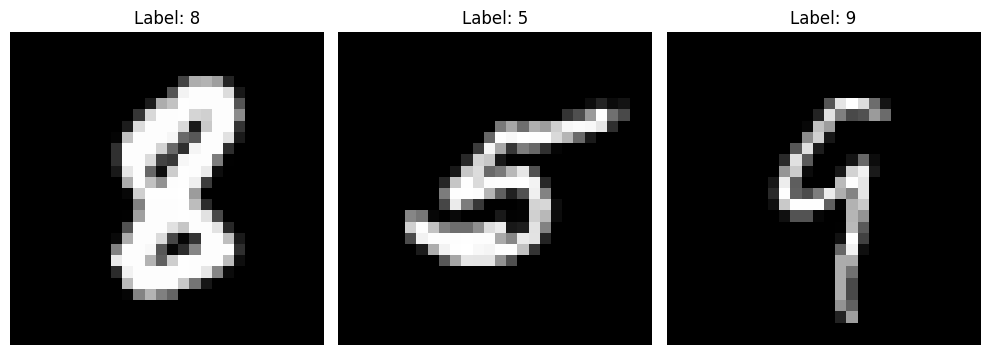

In [4]:
# Print 4 images in a row
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    # Reshape from (784,) to (28, 28) for display
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train_labels[i]}", pad=6)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Testing parameter combinations with grid search

In [5]:
# Define parameters
layer_sizes = [25, 250, 1000]
num_hidden_layers = [0, 1, 2, 3]
etas = np.logspace(0, -2, num=3)
activation_functions = [sigmoid, ReLU, leaky_ReLU]
epochs = [100]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM, train_network_stocastic_momentum, train_network_momentum]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]

In [6]:

total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results1 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # If no hidden layers
    if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
    else:
        # Hidden layers + output layer
        layer_output_sizes = [num_nodes] * num_layers + [10]
        activation_funcs = [act_func] * num_layers + [softmax]

    # Create and train network
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

    optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

    train_pred = NN.predict(X_train)
    val_pred = NN.predict(X_val)
    test_pred = NN.predict(X_test)
    
    train_accuracy = accuracy(train_pred, y_train)
    val_accuracy = accuracy(val_pred, y_val)
    test_accuracy = accuracy(test_pred, y_test)

    # Store results
    results1.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'test_acc': test_accuracy
    })

# Evaluate results
df_results1 = pd.DataFrame(results1)

# Save results to file
df_results1.to_csv("Mnist2500_results_rough.csv", index=False)

  0%|          | 0/432 [00:00<?, ?it/s]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
  0%|          | 2/432 [00:02<10:17,  1.44s/it]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  def

In [41]:
# Load the results from CSV
df_results1 = pd.read_csv("Mnist2500_results_rough.csv")

# Get top 25 configurations
top_50 = df_results1.nlargest(50, 'val_acc').copy()
top_50

,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc
277,2,250,0.01,sigmoid,100,train_network_stocastic_ADAM,0.990667,0.928,0.900
168,1,250,0.01,sigmoid,100,train_network_SRMSprop,0.999333,0.912,0.906
205,1,1000,0.01,sigmoid,100,train_network_stocastic_ADAM,0.990667,0.910,0.894
312,2,1000,0.01,sigmoid,100,train_network_SRMSprop,0.971333,0.910,0.866
204,1,1000,0.01,sigmoid,100,train_network_SRMSprop,0.992000,0.900,0.888
384,3,250,0.01,sigmoid,100,train_network_SRMSprop,0.989333,0.900,0.878
206,1,1000,0.01,sigmoid,100,train_network_stocastic_momentum,0.999333,0.898,0.876
170,1,250,0.01,sigmoid,100,train_network_stocastic_momentum,0.998000,0.894,0.882
276,2,250,0.01,sigmoid,100,train_network_SRMSprop,0.992667,0.886,0.902
132,1,25,0.01,sigmoid,100,train_network_SRMSprop,1.000000,0.882,0.850


In [42]:
print(top_50['n_hidden'].value_counts())
print(top_50['layer_size'].value_counts())
print(top_50['eta'].value_counts())
print(top_50['activation'].value_counts())
print(top_50['optimizer'].value_counts())

n_hidden
0    22
1    12
2    10
3     6
Name: count, dtype: int64
layer_size
25      20
250     16
1000    14
Name: count, dtype: int64
eta
0.01    41
0.10     9
Name: count, dtype: int64
activation
sigmoid       33
ReLU          11
leaky_ReLU     6
Name: count, dtype: int64
optimizer
train_network_SRMSprop              21
train_network_stocastic_ADAM        16
train_network_stocastic_momentum    13
Name: count, dtype: int64


In [9]:
# Define parameters
layer_sizes = [25, 100, 250, 500, 750, 1000]
num_hidden_layers = [0, 1, 2, 3, 4]
etas = [0.01]
activation_functions = [sigmoid]
epochs = [100]
optimizers = [train_network_SRMSprop]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]
n_runs = 10  # Number of runs per configuration

In [10]:
total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results2 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # Arrays to store results from multiple runs
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    # Run the same configuration n_runs times
    for run in range(n_runs):
        # If no hidden layers
        if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [num_nodes] * num_layers + [10]
            activation_funcs = [act_func] * num_layers + [softmax]

        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

        train_pred = NN.predict(X_train)
        val_pred = NN.predict(X_val)
        test_pred = NN.predict(X_test)
        
        train_accuracies.append(accuracy(train_pred, y_train))
        val_accuracies.append(accuracy(val_pred, y_val))
        test_accuracies.append(accuracy(test_pred, y_test))
    
    # Compute averages and standard deviations
    train_acc_mean = np.mean(train_accuracies)
    val_acc_mean = np.mean(val_accuracies)
    test_acc_mean = np.mean(test_accuracies)
    
    train_acc_std = np.std(train_accuracies)
    val_acc_std = np.std(val_accuracies)
    test_acc_std = np.std(test_accuracies)

    # Store results
    results2.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_acc_mean,
        'val_acc': val_acc_mean,
        'test_acc': test_acc_mean,
        'train_acc_std': train_acc_std,
        'val_acc_std': val_acc_std,
        'test_acc_std': test_acc_std
    })

# Evaluate results
df_results2 = pd.DataFrame(results2)

# Save results to file
df_results2.to_csv("Mnist2500_results_depth.csv", index=False)

100%|██████████| 30/30 [3:35:40<00:00, 431.35s/it]  


In [9]:
# Load the results from CSV
df_results2 = pd.read_csv("Mnist2500_results_depth.csv")

# Get top 10 configurations
top_10 = df_results2.nlargest(10, 'val_acc').copy()
top_10


,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc,train_acc_std,val_acc_std,test_acc_std
11,1,1000,0.01,sigmoid,100,train_network_SRMSprop,0.993733,0.9168,0.9080,0.003428,0.010889,0.009960
10,1,750,0.01,sigmoid,100,train_network_SRMSprop,0.996133,0.9112,0.9002,0.001485,0.005810,0.008875
9,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.995467,0.9096,0.8938,0.001950,0.008237,0.012758
14,2,250,0.01,sigmoid,100,train_network_SRMSprop,0.990133,0.9048,0.8892,0.002680,0.012303,0.013151
13,2,100,0.01,sigmoid,100,train_network_SRMSprop,0.997200,0.9030,0.8894,0.000833,0.006588,0.006873
7,1,100,0.01,sigmoid,100,train_network_SRMSprop,0.998667,0.9018,0.8844,0.001333,0.006353,0.004454
8,1,250,0.01,sigmoid,100,train_network_SRMSprop,0.997133,0.9006,0.8882,0.001933,0.017066,0.013280
20,3,250,0.01,sigmoid,100,train_network_SRMSprop,0.987600,0.9004,0.8832,0.007150,0.015253,0.017093
19,3,100,0.01,sigmoid,100,train_network_SRMSprop,0.996200,0.8996,0.8884,0.002405,0.012986,0.006681
25,4,100,0.01,sigmoid,100,train_network_SRMSprop,0.993933,0.8932,0.8858,0.004147,0.011600,0.009009


## Network architecture heatmap

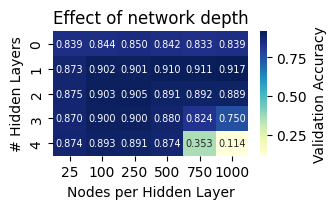

In [ ]:
# Get unique values for the axes (switched)
num_hidden_layers = sorted(df_results2['n_hidden'].unique())
layer_sizes = sorted(df_results2['layer_size'].unique())

# Create 2D array for heatmap (dimensions switched)
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

# Fill the results array with validation accuracy (indices switched)
for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):
        # Filter for this specific combination
        mask = (df_results2['n_hidden'] == num_layers) & (df_results2['layer_size'] == layer_size)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results2[mask]['val_acc'].max()
        else:
            results[i, j] = np.nan

# Create heatmap with new formatting (labels switched)
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=layer_sizes,
            yticklabels=num_hidden_layers,
            cbar_kws={'label': 'Validation Accuracy'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel('Nodes per Hidden Layer')
ax.set_ylabel('# Hidden Layers')
ax.set_title('Effect of network depth', pad=6)
plt.tight_layout()
plt.show()

In [63]:
# Mean accuracy per layer
print('0 layers: ', np.mean([0.839, 0.844, 0.850, 0.842, 0.833, 0.839]))
print('1 layers: ', np.mean([0.873, 0.902, 0.901, 0.910, 0.911, 0.917]))
print('2 layers: ', np.mean([0.875, 0.903, 0.905, 0.891, 0.892, 0.889]))

0 layers:  0.8411666666666667
1 layers:  0.9023333333333333
2 layers:  0.8925000000000001


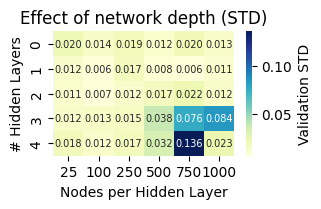

In [10]:
# Get unique values for the axes (switched)
num_hidden_layers = sorted(df_results2['n_hidden'].unique())
layer_sizes = sorted(df_results2['layer_size'].unique())

# Create 2D array for heatmap (dimensions switched)
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

# Fill the results array with validation accuracy (indices switched)
for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):
        # Filter for this specific combination
        mask = (df_results2['n_hidden'] == num_layers) & (df_results2['layer_size'] == layer_size)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results2[mask]['val_acc_std'].max()
        else:
            results[i, j] = np.nan

# Create heatmap with new formatting (labels switched)
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=layer_sizes,
            yticklabels=num_hidden_layers,
            cbar_kws={'label': 'Validation STD'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel('Nodes per Hidden Layer')
ax.set_ylabel('# Hidden Layers')
ax.set_title('Effect of network depth (STD)', pad=6)
plt.tight_layout()
plt.show()

## Activation function test

In [31]:
# Define parameters
layer_sizes = [500]
num_hidden_layers = [1]
etas = np.logspace(-1, -4, num=4)
activation_functions = [sigmoid, ReLU, leaky_ReLU]
epochs = [100]
optimizers = [train_network_SRMSprop]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]
n_runs = 10  # Number of runs per configuration

# Setting the initial layer
init_NN = NeuralNetwork(network_input_size, [500, 10], [sigmoid], cross_entropy)

In [32]:
total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results3 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # Arrays to store results from multiple runs
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    # Run the same configuration n_runs times
    for run in range(n_runs):
        # If no hidden layers
        if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [num_nodes] * num_layers + [10]
            activation_funcs = [act_func] * num_layers + [softmax]

        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)
        NN.layers = copy.deepcopy(init_NN.layers)

        optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

        train_pred = NN.predict(X_train)
        val_pred = NN.predict(X_val)
        test_pred = NN.predict(X_test)
        
        train_accuracies.append(accuracy(train_pred, y_train))
        val_accuracies.append(accuracy(val_pred, y_val))
        test_accuracies.append(accuracy(test_pred, y_test))
    
    # Compute averages and standard deviations
    train_acc_mean = np.mean(train_accuracies)
    val_acc_mean = np.mean(val_accuracies)
    test_acc_mean = np.mean(test_accuracies)
    
    train_acc_std = np.std(train_accuracies)
    val_acc_std = np.std(val_accuracies)
    test_acc_std = np.std(test_accuracies)

    # Store results
    results3.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_acc_mean,
        'val_acc': val_acc_mean,
        'test_acc': test_acc_mean,
        'train_acc_std': train_acc_std,
        'val_acc_std': val_acc_std,
        'test_acc_std': test_acc_std
    })

# Evaluate results
df_results3 = pd.DataFrame(results3)

# Save results to file
df_results3.to_csv("Mnist2500_results_activ.csv", index=False)

  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  lambda ans, x, y: unbroadcast_f(y, lambda g: -g * x / y**2),
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:160: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp, lambda ans, x: lambda g: ans * g)
  8%|▊         | 1/12 [04:17<47:14, 257.71s/it]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encoun

In [20]:
# Load the results from CSV
df_results3 = pd.read_csv("Mnist2500_results_activ.csv")

# Get top 10 configurations
top_12 = df_results3.nlargest(12, 'val_acc').copy()
top_12


,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc,train_acc_std,val_acc_std,test_acc_std
3,1,500,0.0100,sigmoid,100,train_network_SRMSprop,0.996800,0.9152,0.8974,0.001147,0.012040,0.012963
6,1,500,0.0010,sigmoid,100,train_network_SRMSprop,1.000000,0.7778,0.7814,0.000000,0.020483,0.019184
0,1,500,0.1000,sigmoid,100,train_network_SRMSprop,0.787067,0.7168,0.7088,0.345644,0.313897,0.309596
9,1,500,0.0001,sigmoid,100,train_network_SRMSprop,0.916867,0.6020,0.6536,0.003156,0.010621,0.007031
10,1,500,0.0001,ReLU,100,train_network_SRMSprop,0.325133,0.2592,0.2726,0.350010,0.258468,0.278929
7,1,500,0.0010,ReLU,100,train_network_SRMSprop,0.186333,0.1616,0.1602,0.271000,0.214800,0.210600
2,1,500,0.1000,leaky_ReLU,100,train_network_SRMSprop,0.096000,0.0900,0.0900,0.000000,0.000000,0.000000
1,1,500,0.1000,ReLU,100,train_network_SRMSprop,0.096000,0.0900,0.0900,0.000000,0.000000,0.000000
4,1,500,0.0100,ReLU,100,train_network_SRMSprop,0.096000,0.0900,0.0900,0.000000,0.000000,0.000000
5,1,500,0.0100,leaky_ReLU,100,train_network_SRMSprop,0.096000,0.0900,0.0900,0.000000,0.000000,0.000000


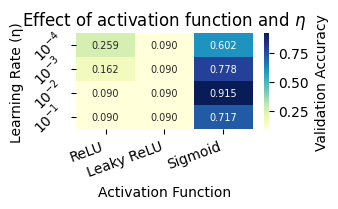

In [19]:
# Get unique values for the axes
learning_rates = sorted(df_results3['eta'].unique())
activation_functions = sorted(df_results3['activation'].unique())

# Create 2D array for heatmap
results = np.zeros((len(learning_rates), len(activation_functions)))

# Fill the results array with validation accuracy
for i, eta in enumerate(learning_rates):
    for j, activation in enumerate(activation_functions):
        # Filter for this specific combination
        mask = (df_results3['eta'] == eta) & (df_results3['activation'] == activation)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results3[mask]['val_acc'].max()
        else:
            results[i, j] = np.nan

yticklabels = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"]
xticklabels = ["ReLU", "Leaky ReLU", "Sigmoid"]

# Create heatmap with new formatting
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            cbar_kws={'label': 'Validation Accuracy'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel('Activation Function')
ax.set_ylabel('Learning Rate (η)')
ax.set_title(r'Effect of activation function and $\eta$', pad=6)
plt.xticks(rotation=20, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

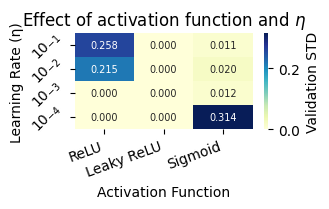

In [15]:
# Get unique values for the axes
learning_rates = sorted(df_results3['eta'].unique())
activation_functions = sorted(df_results3['activation'].unique())

# Create 2D array for heatmap
results = np.zeros((len(learning_rates), len(activation_functions)))

# Fill the results array with validation accuracy
for i, eta in enumerate(learning_rates):
    for j, activation in enumerate(activation_functions):
        # Filter for this specific combination
        mask = (df_results3['eta'] == eta) & (df_results3['activation'] == activation)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results3[mask]['val_acc_std'].max()
        else:
            results[i, j] = np.nan

yticklabels = [r"$10_{-1}$", r"$10_{-2}$", r"$10_{-3}$", r"$10_{-4}$"]
xticklabels = ["ReLU", "Leaky ReLU", "Sigmoid"]

# Create heatmap with new formatting
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            cbar_kws={'label': 'Validation STD'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel('Activation Function')
ax.set_ylabel('Learning Rate (η)')
ax.set_title(r'Effect of activation function and $\eta$', pad=6)
plt.xticks(rotation=20, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Testing cost optimizers

In [ ]:
# Define parameters
layer_sizes = [500]
num_hidden_layers = [1]
etas = [0.01]
activation_functions = [sigmoid]
epochs = [25, 100, 250, 500]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM, train_network_stocastic_momentum, train_network_momentum]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]
n_runs = 10  # Number of runs per configuration

# Setting the initial layer
init_NN = NeuralNetwork(network_input_size, [500, 10], [sigmoid], cross_entropy)

In [35]:
total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results4 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # Arrays to store results from multiple runs
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    # Run the same configuration n_runs times
    for run in range(n_runs):
        # If no hidden layers
        if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [num_nodes] * num_layers + [10]
            activation_funcs = [act_func] * num_layers + [softmax]

        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)
        NN.layers = copy.deepcopy(init_NN.layers)

        optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

        train_pred = NN.predict(X_train)
        val_pred = NN.predict(X_val)
        test_pred = NN.predict(X_test)
        
        train_accuracies.append(accuracy(train_pred, y_train))
        val_accuracies.append(accuracy(val_pred, y_val))
        test_accuracies.append(accuracy(test_pred, y_test))
    
    # Compute averages and standard deviations
    train_acc_mean = np.mean(train_accuracies)
    val_acc_mean = np.mean(val_accuracies)
    test_acc_mean = np.mean(test_accuracies)
    
    train_acc_std = np.std(train_accuracies)
    val_acc_std = np.std(val_accuracies)
    test_acc_std = np.std(test_accuracies)

    # Store results
    results4.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_acc_mean,
        'val_acc': val_acc_mean,
        'test_acc': test_acc_mean,
        'train_acc_std': train_acc_std,
        'val_acc_std': val_acc_std,
        'test_acc_std': test_acc_std
    })

# Evaluate results
df_results3 = pd.DataFrame(results4)

# Save results to file
df_results3.to_csv("Mnist2500_results_optim.csv", index=False)

 19%|█▉        | 3/16 [03:30<14:29, 66.90s/it]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  lambda ans, x, y: unbroadcast_f(y, lambda g: -g * x / y**2),
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:160: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp, lambda ans, x: lambda g: ans * g)
100%|██████████| 16/16 [2:04:25<00:00, 466.57s/it] 


In [22]:
# Load the results from CSV
df_results4 = pd.read_csv("Mnist2500_results_optim.csv")

# Get top 10 configurations
top_16 = df_results4.nlargest(16, 'val_acc').copy()
top_16

,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc,train_acc_std,val_acc_std,test_acc_std
13,1,500,0.01,sigmoid,500,train_network_stocastic_ADAM,0.998467,0.9198,0.8990,0.001231,0.009938,0.007497
12,1,500,0.01,sigmoid,500,train_network_SRMSprop,0.999133,0.9186,0.9050,0.000670,0.008857,0.008591
14,1,500,0.01,sigmoid,500,train_network_stocastic_momentum,0.999733,0.9166,0.8920,0.000327,0.009211,0.009033
8,1,500,0.01,sigmoid,250,train_network_SRMSprop,0.998200,0.9136,0.9028,0.001661,0.009156,0.010591
10,1,500,0.01,sigmoid,250,train_network_stocastic_momentum,0.999600,0.9116,0.8912,0.000680,0.009113,0.012750
9,1,500,0.01,sigmoid,250,train_network_stocastic_ADAM,0.996800,0.9102,0.8896,0.001707,0.010410,0.011236
4,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.996333,0.9092,0.8902,0.002236,0.010008,0.009141
5,1,500,0.01,sigmoid,100,train_network_stocastic_ADAM,0.992933,0.9006,0.8744,0.002816,0.011315,0.015869
6,1,500,0.01,sigmoid,100,train_network_stocastic_momentum,0.996600,0.8992,0.8818,0.004487,0.018723,0.016528
0,1,500,0.01,sigmoid,25,train_network_SRMSprop,0.984600,0.8922,0.8714,0.003870,0.009775,0.016663


[np.int64(25), np.int64(100), np.int64(250), np.int64(500)]
['train_network_SRMSprop', 'train_network_momentum', 'train_network_stocastic_ADAM', 'train_network_stocastic_momentum']


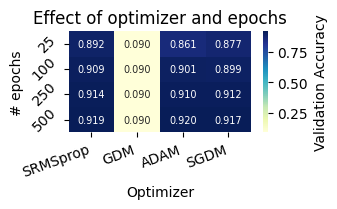

In [35]:
# Get unique values for the axes
learning_rates = sorted(df_results4['n_epochs'].unique())
activation_functions = sorted(df_results4['optimizer'].unique())

print(learning_rates)
print(activation_functions)

# Create 2D array for heatmap
results = np.zeros((len(learning_rates), len(activation_functions)))

# Fill the results array with validation accuracy
for i, eta in enumerate(learning_rates):
    for j, activation in enumerate(activation_functions):
        # Filter for this specific combination
        mask = (df_results4['n_epochs'] == eta) & (df_results4['optimizer'] == activation)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results4[mask]['val_acc'].max()
        else:
            results[i, j] = np.nan

yticklabels = [r"$25$", r"$100$", r"$250$", r"$500$"]
xticklabels = ["SRMSprop", "GDM", "ADAM", "SGDM"]

# Create heatmap with new formatting
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            cbar_kws={'label': 'Validation Accuracy'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel('Optimizer')
ax.set_ylabel('# epochs')
ax.set_title(r'Effect of optimizer and epochs', pad=6)
plt.xticks(rotation=20, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

[np.int64(25), np.int64(100), np.int64(250), np.int64(500)]
['train_network_SRMSprop', 'train_network_momentum', 'train_network_stocastic_ADAM', 'train_network_stocastic_momentum']


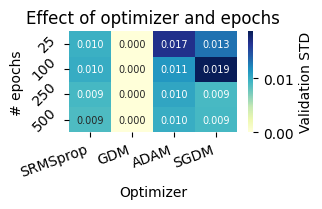

In [ ]:
# Get unique values for the axes
learning_rates = sorted(df_results4['n_epochs'].unique())
activation_functions = sorted(df_results4['optimizer'].unique())

# Create 2D array for heatmap
results = np.zeros((len(learning_rates), len(activation_functions)))

# Fill the results array with validation accuracy
for i, eta in enumerate(learning_rates):
    for j, activation in enumerate(activation_functions):
        # Filter for this specific combination
        mask = (df_results4['n_epochs'] == eta) & (df_results4['optimizer'] == activation)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results4[mask]['val_acc_std'].max()
        else:
            results[i, j] = np.nan

yticklabels = [r"$25$", r"$100$", r"$250$", r"$500$"]
xticklabels = ["SRMSprop", "GDM", "ADAM", "SGDM"]

# Create heatmap with new formatting
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            cbar_kws={'label': 'Validation STD'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel('Optimizer')
ax.set_ylabel('# epochs')
ax.set_title(r'Effect of optimizer and epochs', pad=6)
plt.xticks(rotation=20, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Reg testing

In [36]:
# Define parameters
layer_sizes = [500]
num_hidden_layers = [1]
etas = [0.01]
activation_functions = [sigmoid]
epochs = [100]
optimizers = [train_network_SRMSprop]
cost_functions = [cross_entropy]

# Regulatization parameters
l1_lambdas = [0.0, 0.01, 0.001, 0.0001]
l2_lambdas = [0.0, 0.01, 0.001, 0.0001]

network_input_size = X_train.shape[1]
n_runs = 10  # Number of runs per configuration

# Setting the initial layer
init_NN = NeuralNetwork(network_input_size, [500, 10], [sigmoid], cross_entropy)

In [37]:
total_combinations = len(list(itertools.product(
    num_hidden_layers, layer_sizes, etas, activation_functions, 
    epochs, optimizers, l1_lambdas, l2_lambdas
)))

# Store results
results_regularization = []

for config in tqdm(itertools.product(
    num_hidden_layers, layer_sizes, etas, activation_functions, 
    epochs, optimizers, l1_lambdas, l2_lambdas
), total=total_combinations):
    
    num_layers, num_nodes, eta, act_func, num_epochs, optimizer, l1_lambda, l2_lambda = config

    # Arrays to store results from multiple runs
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    # Run the same configuration n_runs times
    for run in range(n_runs):
        # If no hidden layers
        if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [num_nodes] * num_layers + [10]
            activation_funcs = [act_func] * num_layers + [softmax]

        # Create network
        NN = NeuralNetwork(
            network_input_size, 
            layer_output_sizes, 
            activation_funcs, 
            cross_entropy,
            l1_lambda=l1_lambda,
            l2_lambda=l2_lambda  
        )
        NN.layers = copy.deepcopy(init_NN.layers)
        
        # Train network
        optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

        # Get predictions
        train_pred = NN.predict(X_train)
        val_pred = NN.predict(X_val)
        test_pred = NN.predict(X_test)
        
        train_accuracies.append(accuracy(train_pred, y_train))
        val_accuracies.append(accuracy(val_pred, y_val))
        test_accuracies.append(accuracy(test_pred, y_test))
    
    # Compute statistics
    train_acc_mean = np.mean(train_accuracies)
    val_acc_mean = np.mean(val_accuracies)
    test_acc_mean = np.mean(test_accuracies)
    
    train_acc_std = np.std(train_accuracies)
    val_acc_std = np.std(val_accuracies)
    test_acc_std = np.std(test_accuracies)
    
    # Calculate overfitting gap
    overfit_gap = train_acc_mean - val_acc_mean

    # Store results
    results_regularization.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'l1_lambda': l1_lambda,  # Store L1 value
        'l2_lambda': l2_lambda,  # Store L2 value
        'train_acc': train_acc_mean,
        'val_acc': val_acc_mean,
        'test_acc': test_acc_mean,
        'train_acc_std': train_acc_std,
        'val_acc_std': val_acc_std,
        'test_acc_std': test_acc_std,
        'overfit_gap': overfit_gap  # Track overfitting
    })

# Convert to DataFrame
df_regularization = pd.DataFrame(results_regularization)

# Save results
df_regularization.to_csv("MNIST2500_results_reg.csv", index=False)

100%|██████████| 16/16 [3:22:15<00:00, 758.46s/it]  


In [ ]:
# Load the results from CSV
df_results5 = pd.read_csv("MNIST2500_results_reg.csv")

# Get top 10 configurations
top_16 = df_results5.nlargest(16, 'overfit_gap').copy()
top_16

,n_hidden,layer_size,eta,activation,n_epochs,optimizer,l1_lambda,l2_lambda,train_acc,val_acc,test_acc,train_acc_std,val_acc_std,test_acc_std,overfit_gap
12,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0001,0.0000,0.986667,0.9142,0.8868,0.006007,0.012278,0.010284,0.072467
0,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0000,0.0000,0.995133,0.9108,0.8934,0.001933,0.008352,0.008857,0.084333
3,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0000,0.0001,0.988800,0.9098,0.8908,0.004420,0.010750,0.012812,0.079000
10,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0010,0.0010,0.986600,0.9078,0.8876,0.004093,0.005016,0.013200,0.078800
2,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0000,0.0010,0.990000,0.9074,0.8894,0.004000,0.011101,0.007539,0.082600
14,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0001,0.0010,0.988933,0.9060,0.8946,0.008683,0.012712,0.014030,0.082933
1,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0000,0.0100,0.968200,0.9054,0.8868,0.005190,0.012101,0.008681,0.062800
15,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0001,0.0001,0.991600,0.9044,0.8982,0.002969,0.012800,0.007507,0.087200
9,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0010,0.0100,0.966733,0.9026,0.8812,0.007245,0.010002,0.010591,0.064133
13,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.0001,0.0100,0.970133,0.9006,0.8852,0.011135,0.009035,0.013029,0.069533


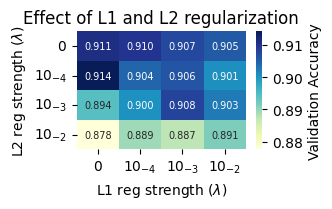

In [61]:
# Get unique values for the axes
learning_rates = sorted(df_results5['l1_lambda'].unique())
activation_functions = sorted(df_results5['l2_lambda'].unique())

# Create 2D array for heatmap
results = np.zeros((len(learning_rates), len(activation_functions)))

# Fill the results array with validation accuracy
for i, eta in enumerate(learning_rates):
    for j, activation in enumerate(activation_functions):
        # Filter for this specific combination
        mask = (df_results5['l1_lambda'] == eta) & (df_results5['l2_lambda'] == activation)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results5[mask]['val_acc'].max()
        else:
            results[i, j] = np.nan

yticklabels = [r"$0$", r"$10_{-4}$", r"$10_{-3}$", r"$10_{-2}$"]
xticklabels = [r"$0$", r"$10_{-4}$", r"$10_{-3}$", r"$10_{-2}$"]

# Create heatmap with new formatting
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            cbar_kws={'label': 'Validation Accuracy'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel(r'L1 reg strength $(\lambda)$')
ax.set_ylabel(r'L2 reg strength $(\lambda)$')
ax.set_title(r'Effect of L1 and L2 regularization', pad=6)
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

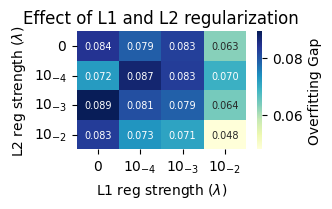

In [60]:
# Get unique values for the axes
learning_rates = sorted(df_results5['l1_lambda'].unique())
activation_functions = sorted(df_results5['l2_lambda'].unique())

# Create 2D array for heatmap
results = np.zeros((len(learning_rates), len(activation_functions)))

# Fill the results array with validation accuracy
for i, eta in enumerate(learning_rates):
    for j, activation in enumerate(activation_functions):
        # Filter for this specific combination
        mask = (df_results5['l1_lambda'] == eta) & (df_results5['l2_lambda'] == activation)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results5[mask]['overfit_gap'].max()
        else:
            results[i, j] = np.nan

yticklabels = [r"$0$", r"$10_{-4}$", r"$10_{-3}$", r"$10_{-2}$"]
xticklabels = [r"$0$", r"$10_{-4}$", r"$10_{-3}$", r"$10_{-2}$"]

# Create heatmap with new formatting
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            cbar_kws={'label': 'Overfitting Gap'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel(r'L1 reg strength $(\lambda)$')
ax.set_ylabel(r'L2 reg strength $(\lambda)$')
ax.set_title(r'Effect of L1 and L2 regularization', pad=6)
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()